# Обучение модели FasterRCNN и YOLOv5 для детекции Helmet

ФИО: Усцов Артем Алексеевич

In [1]:
from IPython.display import Image

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns
import torchvision
import torch
# import PIL
# from PIL import Image
import json

import matplotlib
%matplotlib inline

In [2]:
def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()

def save_to_json(filename, data):
    with open(filename, 'w') as f:
        return json.dump(data, f)
    
def load_from_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)

In [3]:
# Пример изображения с детектируемым объектом
!wget https://github.com/Totenkaf/DL_Homeworks/raw/main/HW_7/helmet.jpg -P data/

--2022-11-12 19:36:49--  https://github.com/Totenkaf/DL_Homeworks/raw/main/HW_7/helmet.jpg
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Totenkaf/DL_Homeworks/main/HW_7/helmet.jpg [following]
--2022-11-12 19:36:49--  https://raw.githubusercontent.com/Totenkaf/DL_Homeworks/main/HW_7/helmet.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67244 (66K) [image/jpeg]
Saving to: ‘data/helmet.jpg’

helmet.jpg          100%[===================>]  65.67K  --.-KB/s    in 0.001s  

2022-11-12 19:36:49 (58.1 MB/s) - ‘data/helmet.jpg’ saved [67244/67244]



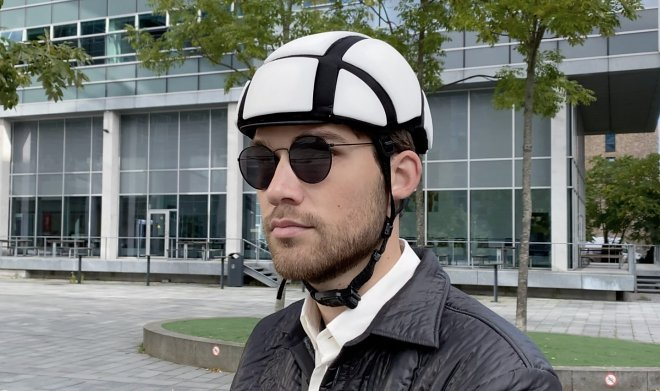

In [4]:
Image(filename='data/helmet.jpg')

* Используем dataset LVIS [link](https://www.lvisdataset.org/)  
* [Репозиторий YOLOv5](https://github.com/ultralytics/yolov5)  
* [Конфигурационный файл](https://github.com/ultralytics/yolov5/blob/master/data/coco128.yaml)

## Обучение модели FasterRCNN

In [5]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1KbwPmpF4Gt4DR3a_SpSOInonnbm1xX33' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1KbwPmpF4Gt4DR3a_SpSOInonnbm1xX33" -O cv_det.zip && rm -rf /tmp/cookies.txt && unzip cv_det.zip && rm -rf cv_det.zip

--2022-11-12 19:57:25--  https://docs.google.com/uc?export=download&confirm=t&id=1KbwPmpF4Gt4DR3a_SpSOInonnbm1xX33
Resolving docs.google.com (docs.google.com)... 142.251.10.101, 142.251.10.102, 142.251.10.113, ...
Connecting to docs.google.com (docs.google.com)|142.251.10.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mmb9dsgpj8jf4ninubja2i9aqnso6ils/1668282975000/16141628694791373514/*/1KbwPmpF4Gt4DR3a_SpSOInonnbm1xX33?e=download&uuid=a6713021-01db-48a5-8b70-475c0dce1c33 [following]
--2022-11-12 19:57:26--  https://doc-0o-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mmb9dsgpj8jf4ninubja2i9aqnso6ils/1668282975000/16141628694791373514/*/1KbwPmpF4Gt4DR3a_SpSOInonnbm1xX33?e=download&uuid=a6713021-01db-48a5-8b70-475c0dce1c33
Resolving doc-0o-ak-docs.googleusercontent.com (doc-0o-ak-docs.googleusercontent.com)... 142.251.10.132, 

In [8]:
!wget http://images.cocodataset.org/zips/train2017.zip -P cv_det/ && unzip cv_det/train2017.zip && mv cv_det/train2017 cv_det/train

--2022-11-12 19:35:35--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.60.121
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.60.121|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘cv_det/train2017.zip’

train2017.zip         1%[                    ] 328.59M  7.97MB/s    eta 30m 39s^C


In [ ]:
!unzip dataset/train2017.zip -d /dataset && mv dataset/train2017 dataset/train

Archive:  dataset/train2017.zip
replace train2017/000000147328.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [14]:
os.chdir('/content/cv_det')
!git clone https://github.com/ultralytics/yolov5  # clone

Cloning into 'yolov5'...
remote: Enumerating objects: 14802, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 14802 (delta 76), reused 96 (delta 50), pack-reused 14669
Receiving objects: 100% (14802/14802), 13.56 MiB | 18.68 MiB/s, done.
Resolving deltas: 100% (10215/10215), done.


In [17]:
os.chdir('/content/cv_det/yolov5') 
!python train.py --data lvis.yaml --cfg yolov5s.yaml --weights '' --batch-size 64

train: weights=, cfg=yolov5s.yaml, data=lvis.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=64, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
Traceback (most recent call last):
  File "train.py", line 630, in <module>
    main(opt)
  File "train.py", line 499, in main
    check_file(opt.data), check_yaml(opt.cfg), check_yaml(opt.hyp), str(opt.weights), str(opt.project)  # checks
  File "/content/cv_det/yolov5/utils/general.py", line 454, in check_file
    assert len(files), f'File not 

In [18]:
os.getcwd()

'/content/cv_det/yolov5'

In [ ]:
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install lvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-w1i0xww0
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-w1i0xww0
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=265182 sha256=e0c83913a1b23ce46a2441c53adeea988833b95bce4aacc144da151e4aa71f50
  Stored in directory: /tmp/pip-ephem-wheel-cache-1hxmojav/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.0.6:
      Successfully uninstalled pycocotools-2.0.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import lvis
from torchvision import transforms
import cv2
import seaborn as sns

In [ ]:
to_tensor = transforms.ToTensor()

def val_transform(img):
    img_tensor = to_tensor(img)
    return img_tensor.unsqueeze(0)

def visualize_prediction(file, model, device='cuda', verbose=True, thresh=0.0, n_colors=None):
    img = Image.open(file)
    img_tensor = val_transform(img)
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model(img_tensor.to(device)) # list of size 1
    prediction = predictions[0]
    
    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features
    
    palette = sns.color_palette(None, n_colors)
    
    # visualize
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    for i in range(len(prediction['boxes'])):
        x1, x2, x3, x4 = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        name = coco_id_to_name[label]
        color = palette[label]
        if verbose:
            if score > thresh:
                print ('Class: {}, Confidence: {}'.format(name, score))
        if score > thresh:
            image = cv2.rectangle(img, (x1, x2), (x3, x4), np.array(color) * 255, 2)
            cv2.putText(image, name, (x1, x2-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, np.array(color) * 255, 2)
    show_image(image)
    return prediction

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import json
from torchvision import transforms


class DetectionDataset(torch.utils.data.Dataset):
    def __init__(self, data_dict_file, images_path, transforms=None):
        self.transforms = transforms
        self.images_path = images_path
        self.lvis_api_data = lvis.LVIS(data_dict_file)
        # with open(data_dict_file, 'r') as f:
        #     self.data_dict = json.load(f)
        
        self.imgs = self.lvis_api_data.load_imgs(list(set(self.lvis_api_data.cat_img_map[556])))
        #list(set(lvis_train_dataset.cat_img_map[556]))
        
    def __getitem__(self, idx):
        # load images ad masks
        img_path = self.images_path + self.imgs[idx]['coco_url'].rpartition('/')[-1]
        try:
            img = Image.open(img_path).convert("RGB")
        except FileNotFoundError as f:
            self.lvis_api_data.download(self.images_path, self.imgs[idx]['id'])
            img = Image.open(img_path).convert("RGB")
        w, h = img.size

        objs = []
        for i in self.lvis_api_data.img_ann_map[self.imgs[idx]['id']]:
            if i['category_id'] == 556:
                objs.append(i)

        num_objs = len(objs)
        boxes = []
        for i in objs:
            bbox = i['bbox']
            xmin = bbox[0]   # * w
            ymin = bbox[1]   # * w
            xdelt = bbox[2]  # * h
            ydelt = bbox[3]  # * h
            boxes.append([xmin, ymin, xmin+xdelt, ymin+ydelt])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        
        # is crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target
    
    def __len__(self):
        return len(self.imgs)

def visualize_from_dataset(dataset: DetectionDataset, idx):
    file = img_path = dataset.images_path + dataset.imgs[idx]['coco_url'].rpartition('/')[-1]
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    objs = []
    objs = dataset.lvis_api_data.img_ann_map[dataset.imgs[idx]['id']]
    num_objs = len(objs)
    for i in objs:
        x_min, y_min, xdelt, ydelt = tuple(i['bbox'])
        y_max = int(y_min+ydelt)
        x_max = int(x_min+xdelt)
        print(type(x_min))
        image = cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
    show_image(image)

In [ ]:
img_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_dataset = DetectionDataset('datasets/LVIS/lvis_v1_train.json', 'datasets/LVIS/train/', img_transforms)
val_dataset = DetectionDataset('datasets/LVIS/lvis_v1_val.json', 'datasets/LVIS/val/', img_transforms)

FileNotFoundError: ignored

In [ ]:
visualize_from_dataset(val_dataset, 1)

In [ ]:
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=collate_fn, drop_last=True)

data_loader_val = torch.utils.data.DataLoader(
    val_dataset, batch_size=4, shuffle=False, num_workers=1,
    collate_fn=collate_fn, drop_last=False)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)

In [ ]:
num_classes = 2
in_channels = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_channels, num_classes=num_classes)

In [ ]:
assert model.roi_heads.box_predictor.cls_score.in_features == 1024
assert model.roi_heads.box_predictor.cls_score.out_features == 2
assert model.roi_heads.box_predictor.bbox_pred.out_features == 8

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# move model to the right device
model.to(device)

for param in model.parameters():
    param.requires_grad = False
for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = True
    
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

In [ ]:
len(params)

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=30,
                                               gamma=0.1)

In [ ]:
from engine import evaluate

In [ ]:
import math
import sys
import time
import torch

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
import utils

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # получим предсказания сети (словарь)        
        loss_dict = model(images, targets)
        # cложим их
        losses = sum(value for value in loss_dict.values())
        loss_value = losses.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            #print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses, **loss_dict)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

In [ ]:
print(devices)

In [ ]:
num_epochs=50
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_val, device=device)
    torch.save(model.state_dict(), 'helmet_fasterrcnn_model_final.pth')

In [ ]:
val_dataset = DetectionDataset('datasets/LVIS/lvis_v1_val.json', 'datasets/LVIS/val/', img_transforms)
data_loader_val = torch.utils.data.DataLoader(
    val_dataset, batch_size=4, shuffle=False, num_workers=1,
    collate_fn=collate_fn, drop_last=False)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# load a model pre-trained pre-trained on COCO
faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)

In [ ]:
num_classes = 2
in_channels = faster_rcnn.roi_heads.box_predictor.cls_score.in_features
faster_rcnn.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_channels, num_classes=num_classes)

In [ ]:
assert faster_rcnn.roi_heads.box_predictor.cls_score.in_features == 1024
assert faster_rcnn.roi_heads.box_predictor.cls_score.out_features == 2
assert faster_rcnn.roi_heads.box_predictor.bbox_pred.out_features == 8

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
faster_rcnn.load_state_dict(torch.load('./helmet_fasterrcnn_model_final.pth', map_location=device))
faster_rcnn.to(device)

In [ ]:
def visualize_prediction_plate(file, model, device='cuda', verbose=True, thresh=0.0, 
                               n_colors=None, id_to_name=None):
    img = Image.open(file)
    img_tensor = val_transform(img)
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model(img_tensor.to(device)) # list of size 1
    prediction = predictions[0]
    
    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features
    
    palette = sns.color_palette(None, n_colors)
    
    # visualize
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    image = img
    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        name = id_to_name[label]
        color = palette[label]
        if verbose:
            if score > thresh:
                print ('Class: {}, Confidence: {}'.format(name, score))
        if score > thresh:
            image = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), np.array(color) * 255, 2)
            cv2.putText(image, name + f": {round(score,2)}", (x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, np.array(color) * 255, 2)
    show_image(image)
    return prediction

In [ ]:
img = Image.open("datasets/LVIS/train/000000144795.jpg")
x_min = img.width*0.4407265-img.width*0.1250781/2
y_min = img.height*0.1490281-img.height*0.2290632/2
x_max = img.width*0.4407265+img.width*0.1250781/2
y_max = img.height*0.1490281+img.height*0.2290632/2
img = cv2.imread("datasets/LVIS/train/000000144795.jpg", cv2.COLOR_BGR2RGB)
palette = sns.color_palette(None, 1)
color = palette[0]
image = cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max),int(y_max)), np.array(color) * 255, 2)
show_image(image)
#cv2.putText(image, "name", (x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, np.array(color) * 255, 2)
print(x_min, y_min, x_max, y_max)

In [ ]:
file_name = "datasets/LVIS/train/000000144795.jpg"

id_to_name = {
    1: "helmet"
    }

visualize_prediction_plate(file_name, faster_rcnn, device=device, id_to_name=id_to_name, thresh=0.7)

In [ ]:
file_name = "helmet_test.jpg"
visualize_prediction_plate(file_name, faster_rcnn, device=device, id_to_name=id_to_name, thresh=0.2)

In [ ]:
file_name = "helmet_test2.jpg"
visualize_prediction_plate(file_name, faster_rcnn, device=device, id_to_name=id_to_name)

In [ ]:
img = np.random.choice(val_dataset.imgs)
img_filename = val_dataset.images_path + img['coco_url'].rpartition('/')[-1]
visualize_prediction_plate(img_filename, faster_rcnn, device=device, id_to_name=id_to_name, thresh=0.5)